# 1. Environment Setup

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
# mRNA_peak_file = doc["mRNA_peak_file"]
# mRNA_peak_150_file = doc["mRNA_peak_150_file"]
supplemental = doc["supplemental"]
#tss_annotation = doc['tss_annotation']

import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
import time

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
from create_output import *
print('Number of tissues: ',len(tissues))

os.chdir(doc["results"])

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
import plot_tss_results
import motif_analysis
from dotenv import load_dotenv
from dotenv.main import dotenv_values

In [3]:
in_dir = "fimo/hg38/TSS.meme/"
peak_f = "genome/hg38/mRNA_150.tss.bed"

## Create directory

In [4]:
out_dir = join(doc["figures"], "motifs", "human") #figures/Figure4/motifs_from_meme/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


## Motif Generation

### Using FIMO

# 1. 

## First do the TSSs used in the final output

### Experimental

--------

--------

--------

--------

# Plotting

In [5]:
from motif_analysis import *

# 1. TSS1 exp vs TSS1 refseq_centered_exp 

## Transform motifs  into binary matrix of presence/absence

Create sequence-by-|basepairs| matrix , fill in with the start of the motif where present. 
fimo output is 1-based indexing 

In [6]:
peak_center = 75 #75 basepairs for each peak

In [42]:
motif_f = os.path.join(in_dir, "fimo.tsv")
peaks_df_exp = read_bed_file(peak_f)
peaks_df_exp = peaks_df_exp[~(peaks_df_exp.index.duplicated())]
motifs_df_exp = pd.read_csv(motif_f,sep="\t",comment="#")
#inr = motifs_df[motifs_df["motif_id"] == "inr.motif"]
motifs_df_exp.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,zfp3.motif,NaN,XM_011540872.2,98,122,+,36.3515,4.260000e-13,1.270000e-05,GGGTCTTGAAGGATGGGTAGGAGTT
1,ronin.motif,NaN,NM_001350173.1,6,25,+,30.5394,5.570000e-13,7.340000e-07,GACTACAACTCCCAGCAGGC
2,ronin.motif,NaN,XM_011513451.2,73,92,+,30.5394,5.570000e-13,7.340000e-07,GACTACAACTCCCAGCAGGC
3,ronin.motif,NaN,XM_011513450.2,73,92,+,30.5394,5.570000e-13,7.340000e-07,GACTACAACTCCCAGCAGGC
4,ronin.motif,NaN,XM_011513457.2,73,92,+,30.5394,5.570000e-13,7.340000e-07,GACTACAACTCCCAGCAGGC


In [44]:
motifs_of_interest = ["tata.motif", "inr.motif"]
#motifs_of_interest = ["ap2.motif"]

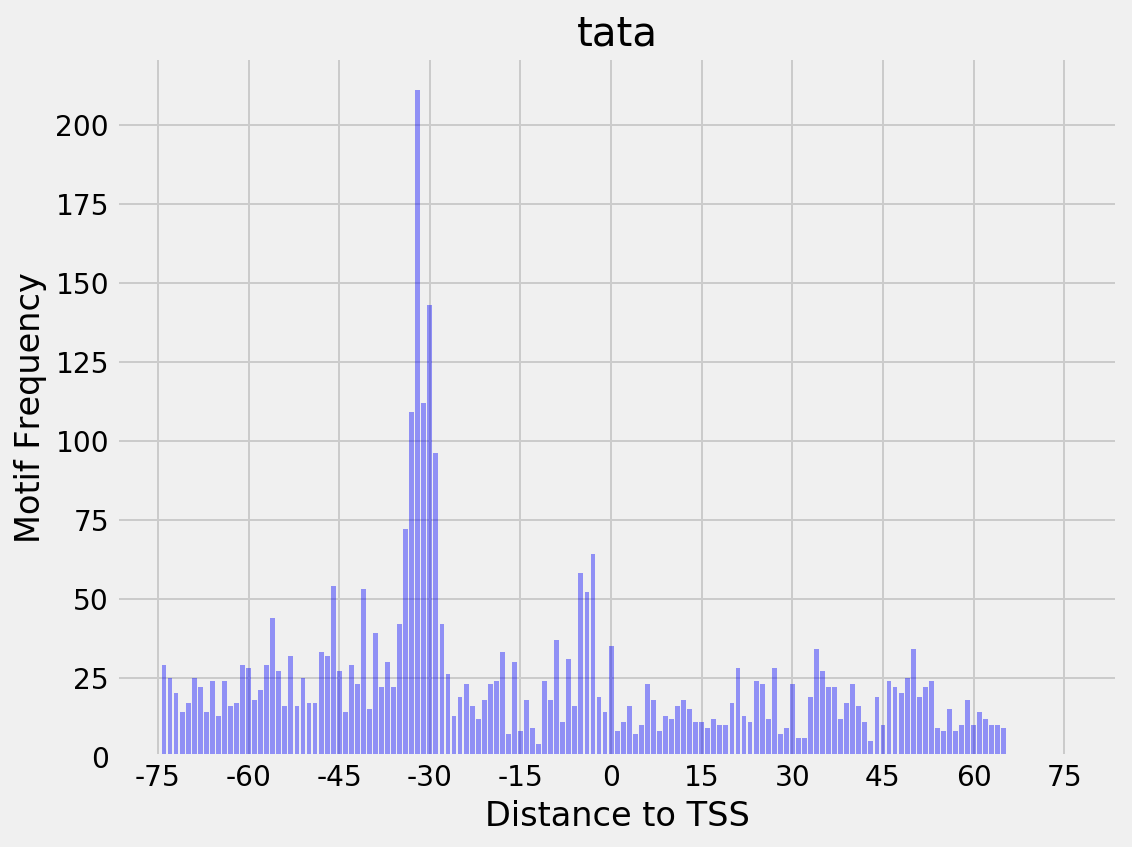

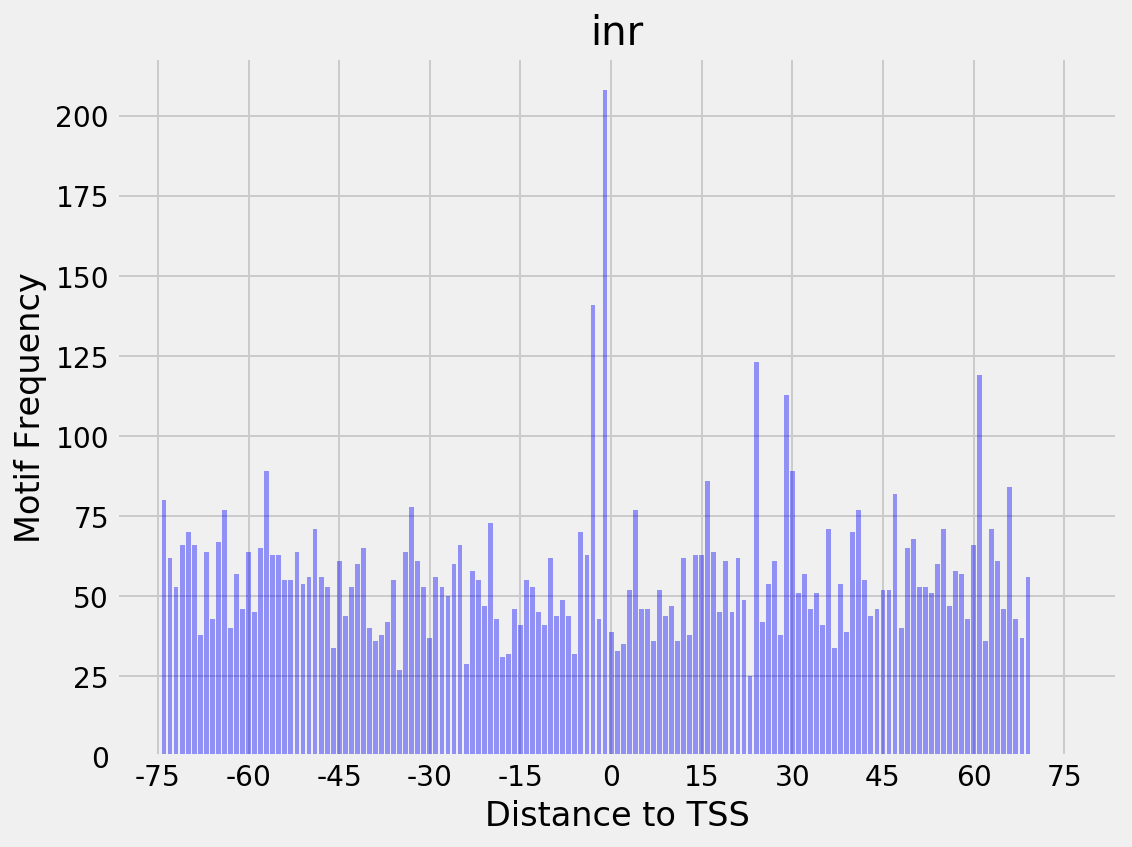

In [61]:
motifs_data = dict()
for m in motifs_of_interest:
    name = m.replace(".motif", "")
    curr_exp = motifs_df_exp[motifs_df_exp["motif_id"] ==  m]
    
    #curr = motifs_df.query("motif_id == 'tata.motif' ")
    num_nts = np.max(curr_exp["stop"])
    
    curr_out_neg_exp = motif_analysis.initialize_motif_df(peaks_df_exp.index,seq_len=num_nts)

    curr_out_pos_exp = motif_analysis.initialize_motif_df(peaks_df_exp.index,seq_len=num_nts)

    
    #first_seq = curr_out.columns.values[0]
    first_seq = curr_out_neg_exp.columns.values[0]
    for ind,val in (curr_exp.iterrows()):
        if val["strand"] == "-":
            curr_out_neg_exp.at[val["sequence_name"],first_seq + val["start"] - 1] = True

    for ind,val in (curr_exp.iterrows()):
        if val["strand"] == "+":
            curr_out_pos_exp.at[val["sequence_name"],first_seq + val["start"] - 1] = True
        
    N = 5
    f,ax = plt.subplots()
    
    y_exp = np.array(curr_out_pos_exp.sum()) +np.array(curr_out_neg_exp.sum())
    motifs_data[name] = pd.DataFrame({"Position":curr_out_neg_exp.columns.values, "Motif Counts Human HG38":y_exp})
    motifs_data[name].to_csv(os.path.join(out_dir, name+".csv"), index=False)
        
    ax.bar(x=range(1, len(y_exp)+1), height= y_exp, color="b", alpha=0.4)
    plt.title(name)
    
    ax.set_xlabel("Distance to TSS")
    ax.set_ylabel("Motif Frequency")
    
    ax.set_xticks(np.arange(-1*peak_center,peak_center+1, 15) + peak_center)
    ax.set_xticklabels(np.arange(-1*peak_center,peak_center+1, 15))


In [64]:
motifs_data["inr"][motifs_data["inr"]["Position"].isin(np.arange(-3,3))]

,Position,Motif Counts Human HG38
72,-3,43.0
73,-2,208.0
74,-1,39.0
75,0,33.0
76,1,35.0
77,2,52.0
